<a href="https://colab.research.google.com/github/jusscarrascosa/brain-tumor-classification-vgg16/blob/main/TP_final_base_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)

###Descripcion de la base de datos

Para este trabajo se utilizó un conjunto de datos de Kaggle que contiene imágenes de resonancia magnética cerebral. Este dataset cuenta con un total de 7,023 imágenes de MRI de cerebros humanos, clasificadas en cuatro categorías: glioma, meningioma, tumor pituitario y ausencia de tumor.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


En la descripcion de esta base de datos no se aclaraba si las imagenes estaban separadas en test y train, entonces habia que chequear

In [ ]:
class_mapping = {
    '0': 'Glioma',
    '1': 'Meningioma',
    '2': 'Pituitary',
    '3': 'NoTumor'
}


In [ ]:
import os

In [ ]:
for root, dirs, files in os.walk(path):
    print(f"Directorio: {root}")
    for d in dirs:
        print(f"  Carpeta: {d}")
    for f in files:
        print(f"  Archivo: {f}")
    break

Directorio: /kaggle/input/brain-tumor-mri-dataset
  Carpeta: Training
  Carpeta: Testing


In [ ]:
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"

print("Clases disponibles en el conjunto de entrenamiento:")
print(os.listdir(train_path))

Clases disponibles en el conjunto de entrenamiento:
['pituitary', 'notumor', 'meningioma', 'glioma']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Preprocesamiento y aumento de datos para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Solo normalización para el test
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)

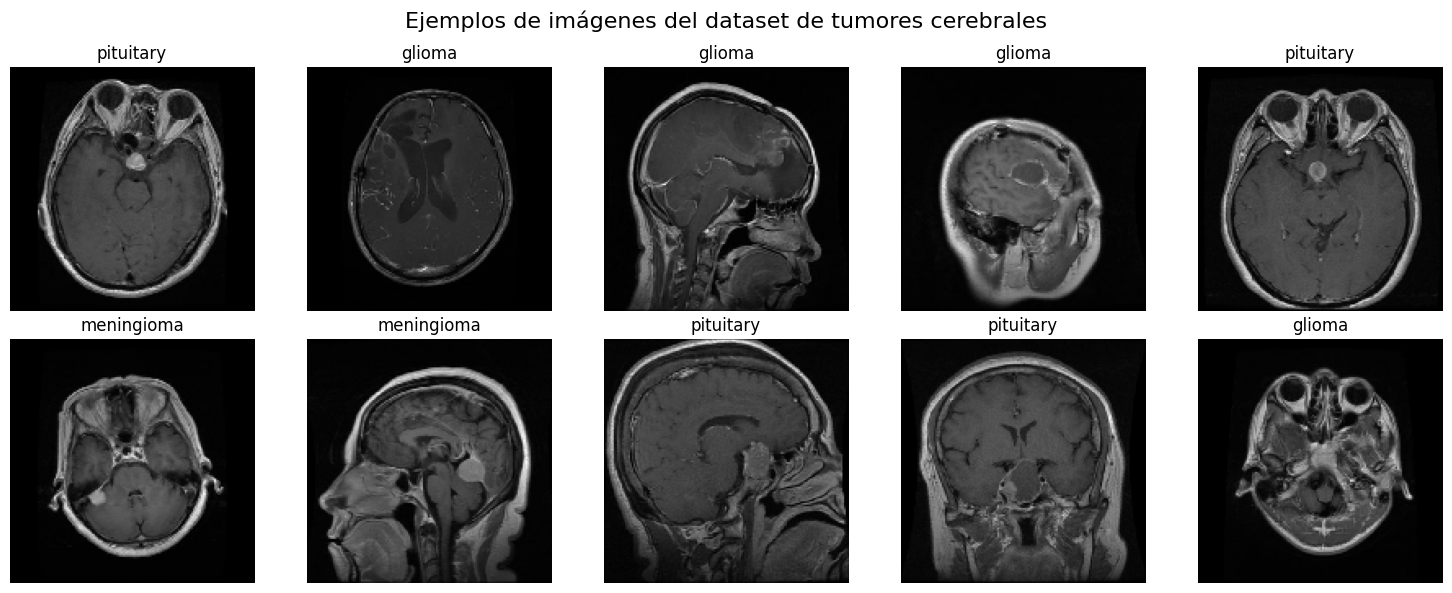

In [ ]:

class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Elegir 10 imágenes aleatorias del batch
indices = np.random.choice(len(X_train), size=10, replace=False)

# Plotear
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    img = X_train[idx]
    label_idx = np.argmax(y_train[idx])  # de one-hot a índice
    label_name = class_labels[label_idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(label_name)
    plt.axis("off")

plt.suptitle("Ejemplos de imágenes del dataset de tumores cerebrales", fontsize=16)
plt.tight_layout()
plt.show()


###Definiendo una CNN

In [ ]:
Imagen_de_entrada1 = layers.Input(shape = (150, 150, 3))
print(Imagen_de_entrada1)

<KerasTensor shape=(None, 150, 150, 3), dtype=float32, sparse=False, name=keras_tensor_47>


In [ ]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(150, 150, 3))

# Bloque 1
x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 2
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 3
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 4
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Clasificación
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Previene overfitting
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(4, activation='softmax')(x)

CNN = models.Model(inputs=input_img, outputs=output)
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CNN.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           26

 Total params: 5,715,716 (21.80 MB)

 Trainable params: 5,714,756 (21.80 MB)

 Non-trainable params: 960 (3.75 KB)

###Entrenamiento

In [ ]:
CNN2 = keras.models.clone_model(CNN)
CNN2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
generador= CNN.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.3891 - loss: 4.7483 - val_accuracy: 0.2288 - val_loss: 1.4905
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.4741 - loss: 1.1528 - val_accuracy: 0.2525 - val_loss: 1.6502
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.4782 - loss: 1.1366 - val_accuracy: 0.4668 - val_loss: 1.1558
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.5096 - loss: 1.0556 - val_accuracy: 0.6674 - val_loss: 0.9001
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.5325 - loss: 1.0463 - val_accuracy: 0.3539 - val_loss: 3.6701
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.5494 - loss: 0.9814 - val_accuracy: 0.6819 - val_loss: 0.7946
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.5644 - loss: 0.9467 - val_accuracy: 0.6827 - val_loss: 0.7458
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.5645 - loss: 0.9172 - val_accu

KeyboardInterrupt: 

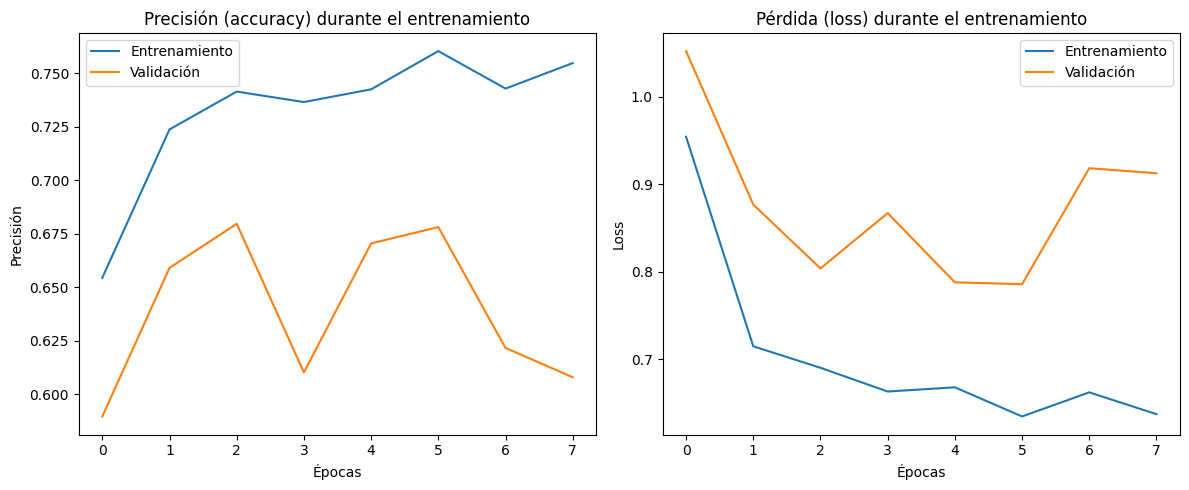

In [ ]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(generador.history['accuracy'], label='Entrenamiento')
plt.plot(generador.history['val_accuracy'], label='Validación')
plt.title('Precisión (accuracy) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(generador.history['loss'], label='Entrenamiento')
plt.plot(generador.history['val_loss'], label='Validación')
plt.title('Pérdida (loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


###Prueba

In [ ]:
# Obtener predicciones sobre todas las imágenes del test
y_pred_probs = CNN2.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Mostrar las 15 primeras predicciones con sus verdaderas etiquetas
for i in range(15):
    print(f"Imagen {i+1}: Predicción = {class_names[y_pred[i]]} | Real = {class_names[y_true[i]]}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step
Imagen 1: Predicción = meningioma | Real = glioma
Imagen 2: Predicción = pituitary | Real = glioma
Imagen 3: Predicción = pituitary | Real = glioma
Imagen 4: Predicción = notumor | Real = glioma
Imagen 5: Predicción = notumor | Real = glioma
Imagen 6: Predicción = meningioma | Real = glioma
Imagen 7: Predicción = glioma | Real = glioma
Imagen 8: Predicción = meningioma | Real = glioma
Imagen 9: Predicción = meningioma | Real = glioma
Imagen 10: Predicción = meningioma | Real = glioma
Imagen 11: Predicción = pituitary | Real = glioma
Imagen 12: Predicción = meningioma | Real = glioma
Imagen 13: Predicción = notumor | Real = glioma
Imagen 14: Predicción = pituitary | Real = glioma
Imagen 15: Predicción = notumor | Real = glioma


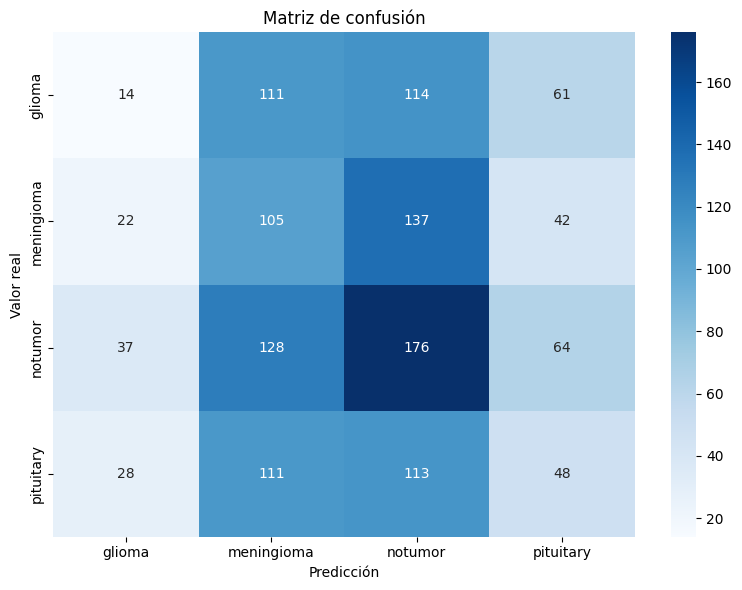

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

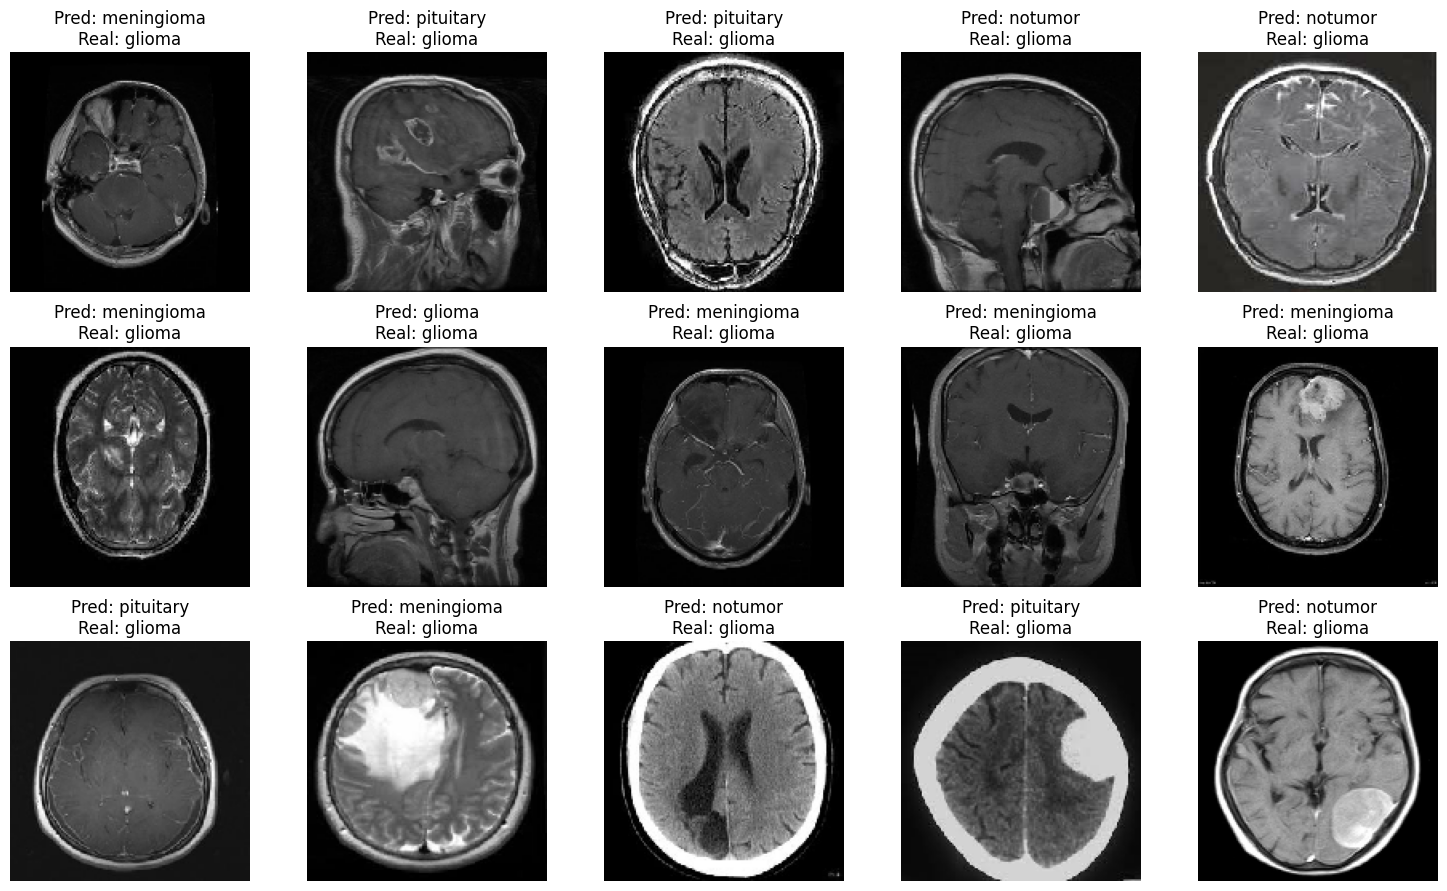

In [ ]:
# Volver a cargar imágenes del test_generator con shuffle=False para que coincidan
test_generator.reset()

# Tomar las primeras 15 imágenes
X_test_sample, _ = next(test_generator)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.ravel()

for i in range(15):
    axs[i].imshow(X_test_sample[i])
    axs[i].set_title(f"Pred: {class_names[y_pred[i]]}\nReal: {class_names[y_true[i]]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

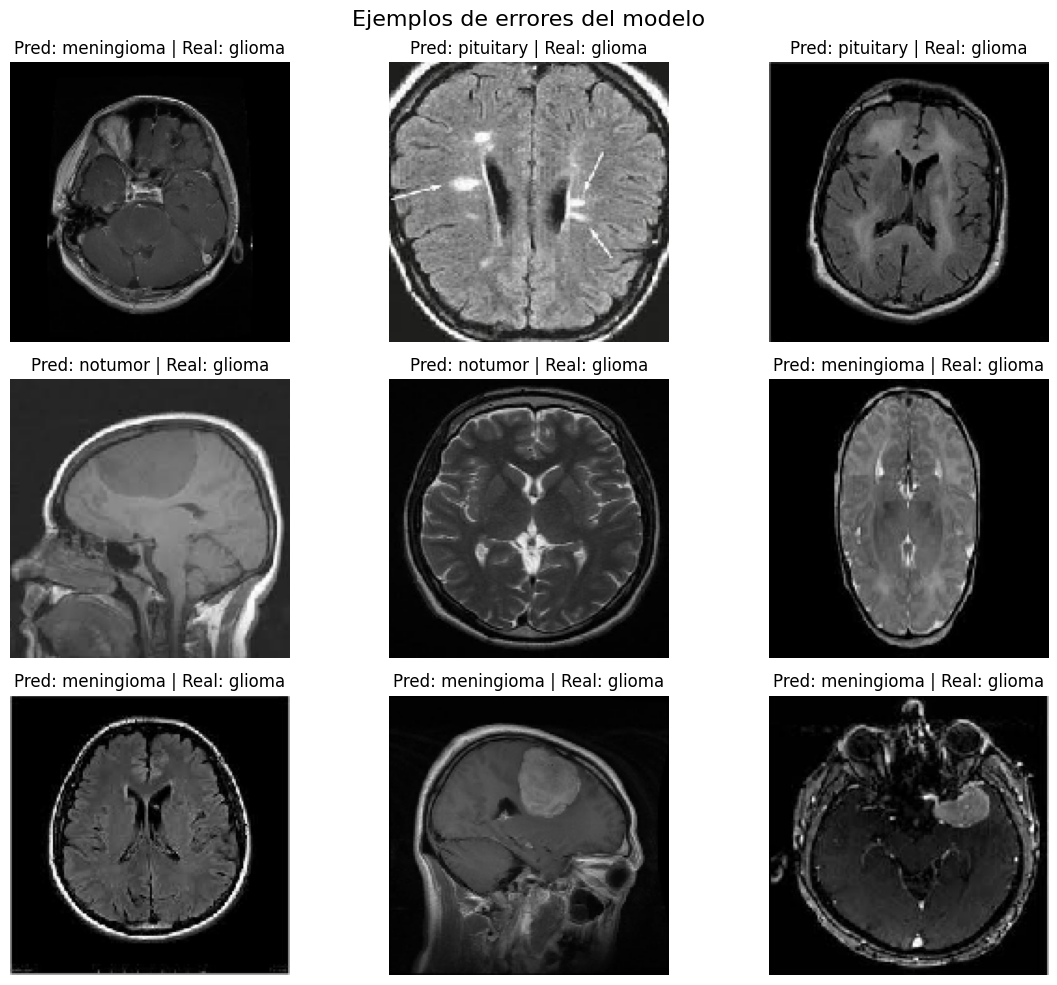

In [ ]:
# Buscar índices donde la predicción fue incorrecta
errores = np.where(y_pred != y_true)[0]

# Graficar 9 ejemplos de errores
plt.figure(figsize=(12, 10))
for i, idx in enumerate(errores[:9]):
    img, _ = test_generator[idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])  # test_generator devuelve batches
    plt.title(f"Pred: {class_names[y_pred[idx]]} | Real: {class_names[y_true[idx]]}")
    plt.axis('off')

plt.suptitle("Ejemplos de errores del modelo", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Reporte de clasificación:\n")
print(report)

Reporte de clasificación:

              precision    recall  f1-score   support

      glioma       0.20      0.22      0.21       300
  meningioma       0.24      0.14      0.18       306
     notumor       0.30      0.41      0.35       405
   pituitary       0.25      0.22      0.24       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.24      1311
weighted avg       0.25      0.26      0.25      1311



###Resultra